✅ Modèle, Scaler et Imputer chargés avec succès.
✅ Données chargées avec succès depuis '../joblib/Cristian/dataset_entrainement_knn_cristian.csv'.
✅ Fonction de prédiction pour SHAP créée.
⏳ Préparation du jeu de données de référence pour SHAP...
✅ Explainer SHAP prêt.
⏳ Calcul des valeurs SHAP pour 50 échantillons...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Calcul SHAP terminé.
📊 Génération du graphique 'Beeswarm'...


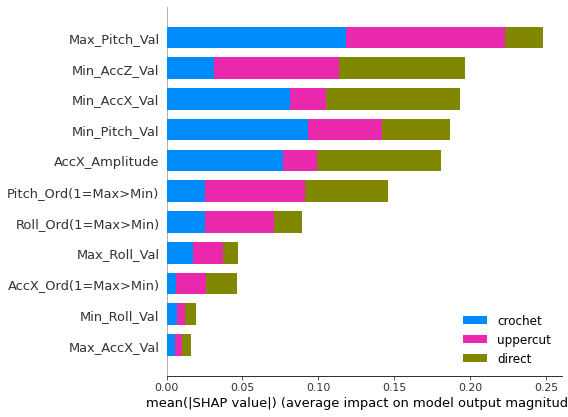

<Figure size 432x288 with 0 Axes>

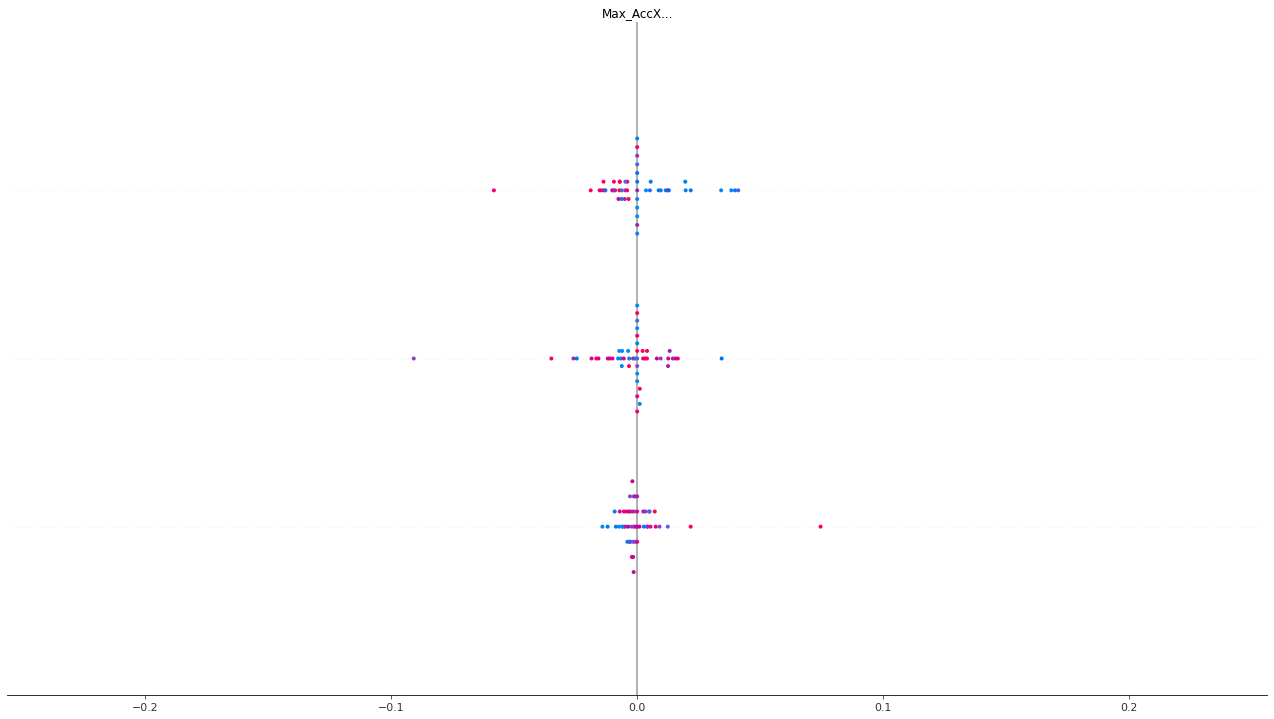

In [1]:
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# --- 1. Définition des constantes et chargement des fichiers ---

# Noms des colonnes 
FEATURES_COLUMNS = [
    'Min_AccX_Val', 'Max_AccX_Val', 'AccX_Amplitude', 'AccX_Ord(1=Max>Min)',
    'Min_AccZ_Val',
    'Max_Roll_Val', 'Min_Roll_Val', 'Roll_Ord(1=Max>Min)',
    'Max_Pitch_Val', 'Min_Pitch_Val', 'Pitch_Ord(1=Max>Min)'
]

# Chemins vers les fichiers sauvegardés
MODEL_PATH = "../joblib/Cristian/knn_model_gant.joblib"
SCALER_PATH = "../joblib/Cristian/scaler_gant.joblib"
IMPUTER_PATH = "../joblib/Cristian/imputer_gant.joblib"
DATA_PATH = "../joblib/Cristian/dataset_entrainement_knn_cristian.csv" 

# Chargement du modèle et des pré-processeurs
try:
    model = joblib.load(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    imputer = joblib.load(IMPUTER_PATH)
    print("✅ Modèle, Scaler et Imputer chargés avec succès.")
except FileNotFoundError as e:
    print(f"❌ ERREUR: Fichier non trouvé - {e}. Vérifiez les chemins.")
    exit()

# Chargement des données pour l'analyse
try:
    df_data = pd.read_csv(DATA_PATH)
    X_full = df_data[FEATURES_COLUMNS]
    print(f"✅ Données chargées avec succès depuis '{DATA_PATH}'.")
except FileNotFoundError:
    print(f"❌ ERREUR: Fichier de données '{DATA_PATH}' non trouvé.")
    exit()
except KeyError:
    print(f"❌ ERREUR: Certaines colonnes de FEATURES_COLUMNS ne sont pas dans '{DATA_PATH}'.")
    exit()

# --- 2. Création de la fonction de prédiction pour SHAP ---

# SHAP KernelExplainer a besoin d'une fonction qui prend un numpy array et renvoie les probabilités du modèle.
def predict_fn(x):
    # x est un numpy array,et on le convertit en DataFrame pour l'imputer
    x_df = pd.DataFrame(x, columns=FEATURES_COLUMNS)
    
    # On applique la même séquence de transformation que pendant l'entraînement
    x_imputed = imputer.transform(x_df)
    x_scaled = scaler.transform(x_imputed)
    
    # Retourner les probabilités de prédiction
    return model.predict_proba(x_scaled)

print("✅ Fonction de prédiction pour SHAP créée.")


# --- 3. Préparation de SHAP KernelExplainer ---

# KernelExplainer a besoin d'un jeu de données "de fond" pour générer des perturbations.
print("⏳ Préparation du jeu de données de référence pour SHAP...")
background_data = shap.kmeans(X_full, 50) # Résume X_full en 50 centroïdes

# Création de l'explainer
explainer = shap.KernelExplainer(predict_fn, background_data)
print("✅ Explainer SHAP prêt.")


# --- 4. Calcul des valeurs SHAP et visualisation ---

X_to_explain = X_full.sample(n=50, random_state=42) # On explique 50 échantillons aléatoires

print(f"⏳ Calcul des valeurs SHAP pour {len(X_to_explain)} échantillons...")
shap_values = explainer.shap_values(X_to_explain)
print("✅ Calcul SHAP terminé.")

# Affichage du graphique "Beeswarm"
# Ce graphique montre l'impact de chaque feature sur la prédiction pour chaque classe.
print("📊 Génération du graphique 'Beeswarm'...")
shap.summary_plot(
    shap_values,
    X_to_explain,
    feature_names=FEATURES_COLUMNS,
    class_names=model.classes_,
    plot_type='bar' # Affiche le barplot
)

shap.summary_plot(
    shap_values,
    X_to_explain,
    feature_names=FEATURES_COLUMNS,
    class_names=model.classes_, # Affiche le Beeswarm plot,
    max_display=11
)
plt.show()